In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2

import pickle
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import matplotlib.ticker as ticker
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from vit_keras import vit
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from vit_keras.layers import ClassToken, AddPositionEmbs, TransformerBlock
from keras.layers import LayerNormalization

import tensorflow.keras.backend as K
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import confusion_matrix
from typing import Dict, List
import itertools

from image_load import *
from keras.models import load_model


from plotting import loss_accuracy_graph_from_pickle, bar_accuracy_plot, scatter_plot, confusion_matrices


In [11]:
#load trained models:
model_names = ["resnet", "inception", "vgg", "vit-b16", "vit-b32"]
model_dict = {}


model_dict["resnet"] = load_model("models and histories/resnet_model.h5")
model_dict["inception"] = load_model("models and histories/inception_model.h5")
model_dict["vgg"] = load_model("models and histories/vgg16_model.h5")

model_dict["vit-b16"] = load_model("models and histories/b16_model.h5")
model_dict["vit-b32"] = load_model("models and histories/b32_model.h5")

In [3]:
#load histories by pickle
history_dict = {}

history_dict["resnet"] =  pickle.load(open("models and histories/resnet_history.pickle","rb"))
history_dict["inception"] =  pickle.load(open("models and histories/inception_history.pickle","rb"))
history_dict["vgg"] =  pickle.load(open("models and histories/vgg16_history.pickle","rb"))

history_dict["vit-b16"] =  pickle.load(open("models and histories/b16_history.pickle","rb"))
history_dict["vit-b32"] =  pickle.load(open("models and histories/b32_history.pickle","rb"))

c_val_result_dict =  pickle.load(open("models and histories/data_dictionary.pickle","rb"))


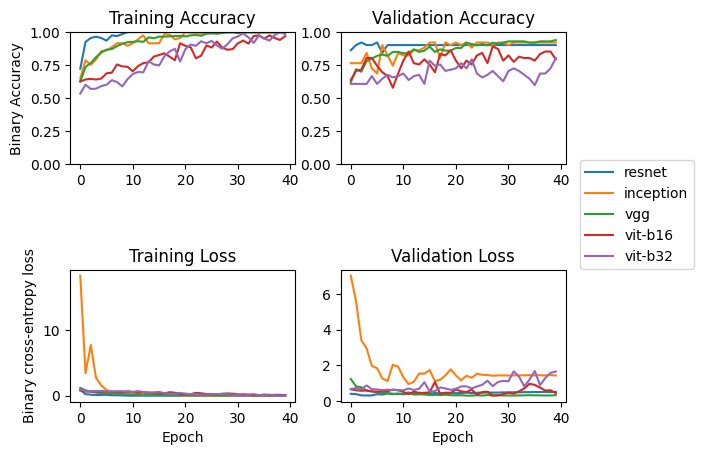

<Figure size 2200x2200 with 0 Axes>

In [4]:
# make loss and accuracy learning plots

loss_accuracy_graph_from_pickle(history_dict)


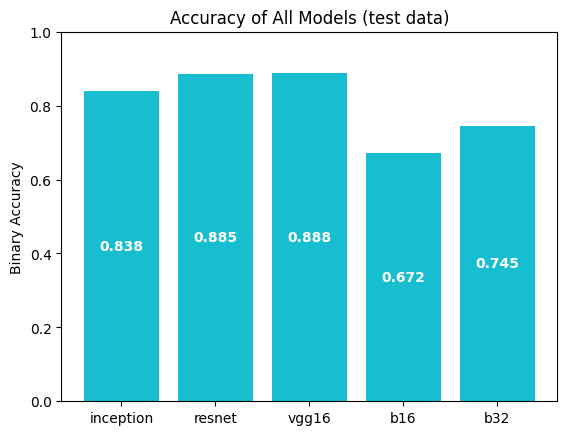

In [5]:
bar_accuracy_plot(c_val_result_dict)

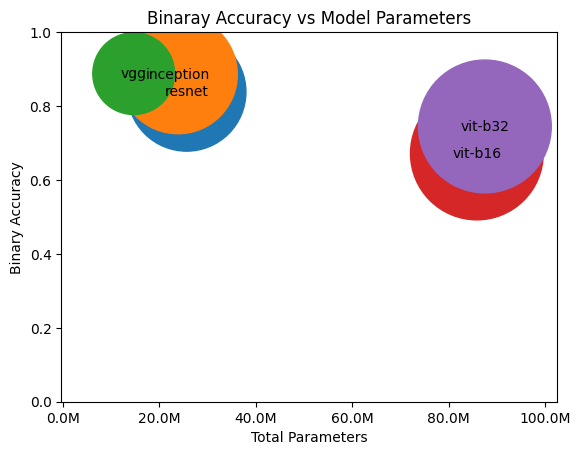

In [6]:
scatter_plot(model_dict, c_val_result_dict)

model: resnet
8/8 [==============================] - 19s 2s/step
model: inception
8/8 [==============================] - 11s 1s/step
model: vgg
8/8 [==============================] - 42s 5s/step
model: vit-b16
8/8 [==============================] - 77s 9s/step
model: vit-b32
8/8 [==============================] - 21s 2s/step


<Figure size 2000x3500 with 0 Axes>

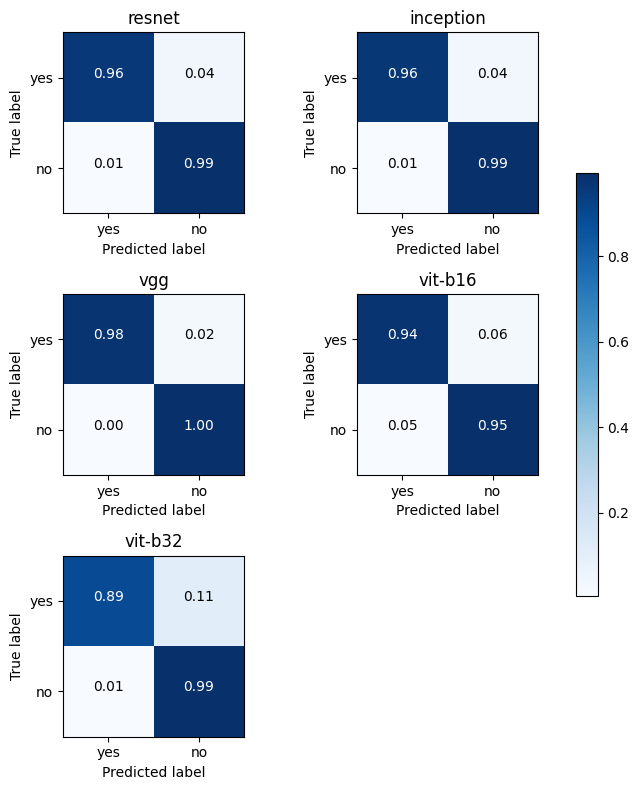

In [7]:
x, y = load_images_method_2(image_input_size=224)   #THIS MIGHT HAVE TO BE ONLY TEST DATA WHICH IT IS NOT TRAINED ON, BUT FOR NOW DO IT LIKE THIS
# y = reformat_labels(y)
confusion_matrices(model_dict, x, y)

In [8]:
def heatmap_func(model: Model, layer):
    
    print("output:", layer.output)

    new_model = tf.keras.models.Model(model.inputs, layer.output)

    # Choose a random input image to generate the heatmap for
    img = np.random.rand(1, 224, 224, 3)

    preds = model.predict(img)
    class_idx = np.argmax(preds[0])

    with tf.GradientTape() as tape:
        last_conv_layer_output = new_model(img)
        tape.watch(last_conv_layer_output)
        preds = model(img)
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, last_conv_layer_output)

    weights = tf.reduce_mean(grads, axis=(1, 2))

    heatmap = tf.reduce_sum(tf.multiply(weights, last_conv_layer_output), axis=-1)

    # Normalize the heatmap to be between 0 and 1
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    # Show the heatmap on top of the input image
    plt.imshow(img[0])
    plt.imshow(heatmap[0], alpha=0.5, cmap='jet')
    plt.show()


def heatmap(model, img):
    last_conv_output, pred = model.predict(img)
    last_conv_output = last_conv_output[0]
    pred = pred[0]
    get_output = K.function([model.layers[0].input], [model.layers[-1].output])

    # Get the output tensor for the given input image
    output = get_output([img])[0]

    # Find the class activation map
    class_idx = np.argmax(output[0])
    class_output = output[:, class_idx]
    grads = K.gradients(class_output, last_conv_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img[0], 0.5, heatmap, 0.5, 0)
    return superimposed_img

def heatmap2(model_dict = Dict[str, Model], img_size =224):
    model = model_dict["resnet"]
    conv_layer = model.get_layer('conv5_block3_out')
    classifier_layer = model.layers[-1]
    heatmap_model = Model(inputs=model.input, outputs=[conv_layer.output, classifier_layer.output])
    
    img_path = 'brain_tumor_dataset/yes/Y1.jpg'
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    heatmap_img = heatmap(heatmap_model, x)

        
heatmap2(model_dict, 224)

1/1 [==============================] - 2s 2s/step


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [13]:

model = model_dict["vit-b16"]
model.summary()
model = model_dict["vit-b32"]

model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      